In [1]:
from random import shuffle
from queue import Queue
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from utils import str_key, set_dict, get_dict


In [2]:
class Gamer():
    """
    游戏者
    """
    def __init__(self, name="", A=None, display=False):
        self.role = None
        self.name = name
        self.cards = [] # 定义手中的牌
        self.display = display # 是否显示对局文字信息
        self.policy = None # 策略
        self.learning_method = None # 学习方法
        self.A = A # 行为空间
    def __str__(self):
        return self.name
    def _value_of(self,card):
        """
        根据牌的字符判断牌的数值大小,A被输出为1,JQK均为10,其余按照牌字符对应的数字取值
        :param card: 牌面信息 str
        :return: 牌的数值大小,A返回1
        """
        try:
            v = int(card)
        except:
            if card == "A":
                v = 1
            elif card in ['J', 'Q', 'K']:
                v = 10
            else:
                v = 0
        finally:
            return v
    def get_points(self):
        """
        统计手牌分数,如果使用了A的1点,同时返回True
        :param cards 庄家或者玩家手中的牌
        :return: tuple(返回牌的总点数,是否使用了可复用的A)
        """
        num_of_useable_ace = 0 # 默认没有拿到Ace
        total_point = 0 # 总值
        cards = self.cards
        if cards is None:
            return 0, False
        for card in cards:
            v = self._value_of(card)
            if v == 1:
                num_of_useable_ace += 1
                v = 11
            total_point += v
        while total_point > 21 and num_of_useable_ace > 0:
            total_point -= 10
            num_of_useable_ace -= 1
        return total_point, bool(num_of_useable_ace)
    def receive(self, cards=[]):
        """
        玩家获得一张或者多张牌
        :param cards:
        :return:
        """
        cards = list(cards)
        for card in cards:
            self.cards.append(card)
    def discharge_cards(self):
        """
        玩家把手中的牌清空,然后扔牌
        :return:
        """
        self.cards.clear()
    def cards_info(self):
        """
        玩家手牌信息,显示牌面具体信息
        :return:
        """
        self._info("{}{}现在的牌:{}\n".format(self.role, self.name, self.cards))
    def _info(self, msg):
        if self.display:
            print(msg, end=" ")

In [3]:
class Dealer(Gamer):
    """
    庄家
    """
    def __init__(self, name="", A=None, display=False):
        super(Dealer,self).__init__(name, A, display)
        self.role = "庄家" # 角色
        self.policy = self.dealer_policy # 策略

    def first_card_value(self):
        """
        显示第一张明牌
        :return:
        """
        if self.cards is None or len(self.cards) == 0:
            return 0
        return self._value_of(self.cards[0])
    def dealer_policy(self, Dealer=None):
        """
        庄家策略的细节
        :param Dealer:
        :return:
        """
        action = ""
        dealer_ponits,_ = self.get_points()
        if dealer_ponits >= 17:
            action = self.A[1] # 停止叫牌
        else:
            action = self.A[0] # 继续叫牌
        return action


In [4]:
class Player(Gamer):
    """
    玩家
    """
    def __init__(self, name="", A=None, display=False):
        super(Player,self).__init__(name,A,display)
        self.policy = self.naive_policy
        self.role = "玩家"
    def get_state(self,dealer):
        dealer_first_card_value = dealer.first_card_value()
        player_points, useable_ace = self.get_points()
        return dealer_first_card_value, player_points, useable_ace
    def get_state_name(self,dealer):
        return str_key(self.get_state(dealer))
    def naive_policy(self, dealer=None):
        player_points, _ =self.get_points()
        if player_points < 20:
            action = self.A[0]
        else:
            action = self.A[1]
        return action

In [5]:
class Arena():
    """
    游戏管理类
    """
    def __init__(self, display=None, A=None):
        self.cards = ['A','2','3','4','5','6','7','8','9','10','J','Q','K']*4
        self.card_q = Queue(maxsize=52) # 洗好牌的发牌器
        self.cards_in_pool = [] # 已经用过的公开的牌
        self.display = display
        self.episodes = [] #产生的对局信息列表
        self.load_cards(self.cards) # 把初始的52张牌装入发牌器
        self.A = A # 获得行为空间
    def load_cards(self,cards):
        """
        把收集的牌洗一洗,重新装到发牌器中
        :param cards: 要装入发牌器中的多张牌list
        :return: None
        """
        shuffle(cards) # 洗牌
        for card in cards:
            # 将洗好的牌依次放入队列
            self.card_q.put(card)
        cards.clear() # 将原来的牌清空
        return
    def reward_of(self, dealer, player):
        """
        判断玩家奖励值,附带玩家、庄家的牌点信息
        :param dealer:
        :param player:
        :return:
        """
        dealer_points, _ = dealer.get_points()
        player_points, useable_ace = player.get_points()
        if player_points > 21:
            reward = -1
        else:
            if player_points > dealer_points or dealer_points > 21:
                reward = 1
            elif player_points == dealer_points:
                reward = 0
            else:
                reward = -1
        return reward, player_points, dealer_points, useable_ace
    def serve_card_to(self, player, n=1):
        """
        给庄家或者玩家发牌，如果牌不够则将公开牌池的牌洗一洗重新发牌
        :param player:
        :param n:
        :return:None
        """
        cards = [] # 将要发出的牌
        for _ in range(n):
            # 考虑发牌器没有牌的情况
            if self.card_q.empty():
                self._info("\n发牌器没有牌了，整理废牌，重新洗牌；")
                shuffle(self.cards_in_pool)
                self._info("一共整理了{}张已经使用的牌，重新放入发牌器\n".format(len(self.cards_in_pool)))
            # assert(len(self.cards_in_pool)>20) # 确保依次能够收集较多的牌
            # 代码编写不合理时，可能会出现一方爆点时还会持续叫牌
                self.load_cards(self.cards_in_pool) # 将收集来的用过的牌洗好送入发牌器重新使用
            cards.append(self.card_q.get())
        self._info("发了{}张牌({})给{}{}".format(n, cards, player.role, player))
        player.receive(cards) # 某玩家接受发出的牌
        player.cards_info()
    def _info(self, msg):
        if self.display:
            print(msg, end="")
    def recycle_cards(self, *players):
        """
        回收玩家手中的牌到公开使用的牌池中
        :param players:
        :return:
        """
        if len(players) == 0:
            return
        for player in players:
            for card in player.cards:
                self.cards_in_pool.append(card)
            player.discharge_cards() # 玩家清空手牌
    def play_game(self, dealer, player):
        """
        玩一局21点，生成一个状态序列以及最终奖励（中间奖励为0）
        :param dealer: 庄家
        :param player: 玩家
        :return: tuple(episode, reward)
        """
        self._info("开始新一局".center(20,"=") + '\n')
        self.serve_card_to(player, n=2) # 发两张牌给玩家
        self.serve_card_to(dealer, n=2) # 发两张牌给庄家
        episode = [] # 记录一个对局信息
        if player.policy is None:
            self._info("玩家需要一个策略")
            return
        if dealer.policy is None:
            self._info("庄家需要一个策略")
            return
        while True:
            action = player.policy(dealer)
            # 玩家的策略产生一个行为
            self._info("{}{}选择:{};".format(player.role, player.name, action))
            episode.append((player.get_state_name(dealer), action)) # 记录一个(s,a)
            if action == self.A[0]:
                # 继续叫牌
                self.serve_card_to(player) # 发一张牌给玩家
            else:
                # 停止叫牌
                break
        # 玩家停止叫牌后要计算玩家手中的点数，玩家如果爆了，庄家就不用继续了
        reward, player_points, dealer_points, useable_ace = self.reward_of(dealer, player)
        if player_points > 21:
            self._info("玩家爆点{}输了，得分:{}\n".format(player_points,reward))
            self.recycle_cards(player, dealer)
            self.episodes.append((episode, reward)) # 预测的时候需要形成episode list后集中学习V
            # 在蒙特卡罗控制的时候，可以不需要episode列表，生成一个episode学习一个
            self._info("本局结束".center(20,"=") + '\n')
            return episode, reward
        # 玩家没有超过21点
        self._info('\n')
        while True:
            action = dealer.policy() # 庄家根据其策略获取一个行为
            self._info("{}{}选择:{};".format(dealer.role, dealer, action))
            # 状态只记录庄家第一张牌的信息，此时玩家不再叫牌，(s,a)不必重复记录
            if action == self.A[0]:
                # 庄家继续叫牌
                self.serve_card_to(dealer)
            else:
                break
        # 双方停止叫牌
        self._info("\n双方均停止叫牌;\n")
        reward, player_points, dealer_points, useable_ace = self.reward_of(dealer, player)
        player.cards_info()
        dealer.cards_info()
        if reward == 1:
            self._info("玩家赢了！")
        elif reward == -1:
            self._info("玩家输了！")
        else:
            self._info("双方和局！")
        self._info("玩家{}点，庄家{}点\n".format(player_points,dealer_points))
        self._info("本局对局结束".center(20,"=") + '\n')
        self.recycle_cards(player, dealer) # 回收玩家和庄家的牌到公开牌池
        self.episodes.append((episode, reward)) # 将刚才产生的完整对局添加值状态序列列表，蒙特卡罗控制不需要
        return episode, reward
    def play_games(self, dealer, player, num=2, show_statistic = True):
        """
        一次性生成多个对局
        :param dealer:
        :param player:
        :param num:
        :param show_statistic:
        :return:
        """
        results = [0,0,0] #玩家负、和、赢的局数
        self.episodes.clear()
        for _ in tqdm(range(num)):
            episode, reward = self.play_game(dealer, player)
            results[1+reward] += 1
            if player.learning_method is not None:
                player.learning_method(episode, reward)
        if show_statistic:
            self._info("共玩了{}局，玩家赢了{}局，和{}局， 输{}局， 胜率:{:.2f}, 不输率:{:.2f}\n".format(num, results[2], results[1], results[0], results[2]/num, (results[1] + results[2])/num))
        return

In [6]:
A = ["继续叫牌", "停止叫牌"]
display = False
# 创建一个玩家和一个庄家使用原始策略
player = Player(name="maqi", A=A, display=display)
dealer = Dealer(name="maxu", A=A, display=display)

# 创建一个场景
arena = Arena(A=A, display=display)
# 生成num个完整对局
arena.play_games(dealer, player, num = 200000)

100%|██████████| 200000/200000 [00:14<00:00, 14111.02it/s]


## 策略评估
我们前面的对局数据都保存在arena.episodes中，接下来的工作就是使用这些数据来对player的策略进行评估

In [7]:
def policy_evaluate(episodes, V, Ns):
    """
    统计个体状态的价值，衰减因子为1，中间状态的即时奖励为0， 递增式蒙特卡罗评估
    :param episodes:
    :param V:
    :param Ns:
    :return:
    """
    for episode, r in episodes:
        for s, a in episode:
            ns = get_dict(Ns, s)
            v = get_dict(V, s)
            set_dict(Ns, ns+1, s)
            set_dict(V, v+(r-v)/(ns+1), s)
V = {} # 状态价值字典
Ns = {} # 状态被访问的次数节点
policy_evaluate(arena.episodes, V, Ns) # 学习V值


C:\Users\MaQi\AppData\Local\Temp\ipykernel_10752\3685442733.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


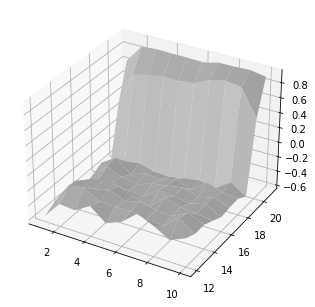

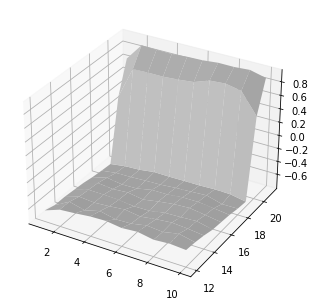

In [8]:
def draw_value(value_dict, useable_ace = True, is_q_dict = False, A = None):
    # 定义figure
    fig = plt.figure()
    # 将figure变成3D
    ax = Axes3D(fig)
    # 定义x，y
    x = np.arange(1, 11, 1) # 庄家第一张牌
    y = np.arange(12, 22, 1) # 玩家总分数
    # 生成网格数据
    X, Y = np.meshgrid(x,y)
    # 从V字典检索Z轴的高度
    row, col = X.shape
    Z = np.zeros((row, col))
    if is_q_dict:
        n = len(A)
    for i in range(row):
        for j in range(col):
            state_name = str(X[i,j]) + "_" + str(Y[i,j]) + "_" + str(useable_ace)
            if not is_q_dict:
                Z[i,j] = get_dict(value_dict, state_name)
            else:
                assert (A is not None)
                for a in A:
                    new_state_name = state_name + "_" + str(a)
                    q = get_dict(value_dict, new_state_name)
                    if q>=Z[i,j]:
                        Z[i,j] = q
    # 绘制3D曲面
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, color="lightgray")
    plt.show()

# 绘制有可用的ACE时的状态价值图
draw_value(V, useable_ace=True, A=A)
# 绘制无可用的A时状态价值图
draw_value(V, useable_ace=False, A=A)

